In [1]:
from src.data.utils import read_data
import pandas as pd
import numpy as np

data_S2 = read_data('../data/raw/unlabeled/S1_mapA_11x11.txt')
data_S2bkg = read_data('../data/raw/unlabeled/S1_bkg_mapA_11x11.txt')

In [2]:
data_S2.head()

,wl,r1c1,r1c2,r1c3,r1c4,r1c5,r1c6,r1c7,r1c8,r1c9,...,r11c2,r11c3,r11c4,r11c5,r11c6,r11c7,r11c8,r11c9,r11c10,r11c11
0,99.96584,190.1434,187.9253,308.6719,238.5942,426.8270,252.8237,210.4182,126.6570,258.5993,...,177.7000,655.8368,276.2520,157.3897,162.8413,209.0144,722.3541,135.8171,4124.057,158.6143
1,100.93010,191.1912,189.8875,307.2245,238.6626,427.8990,251.7786,211.2901,126.3902,258.8720,...,176.4870,656.9011,275.8766,156.9539,163.0879,208.3326,721.3859,134.6625,4118.137,158.4630
2,102.85850,190.5066,190.7589,306.0538,239.3010,427.9786,251.6285,212.0103,125.9097,260.0114,...,176.1386,656.9066,275.2296,157.1984,163.9934,210.6225,719.4830,134.2782,4117.683,158.7242
3,103.82280,189.7992,191.9812,305.0783,240.6263,429.6259,252.4784,213.5408,125.9985,261.5041,...,176.0833,657.7156,275.5419,157.8207,164.9507,214.7042,718.3871,135.0785,4120.368,159.6978
4,105.75120,190.1394,192.2761,305.6989,241.1965,431.7348,253.8204,214.2907,126.9272,261.3828,...,176.4648,658.6905,277.0084,158.1157,164.4863,216.0107,720.1598,136.7106,4123.122,160.4451


In [3]:
wl = data_S2.wl
data = data_S2[[f'r{k}c{i}' for k in range(1, 12) for i in range(1, 12)]]
data_bkg = data_S2bkg[[f'r{k}c{i}' for k in range(1, 12) for i in range(1, 12)]]

## Sanity check of the data

In [4]:
assert data.isna().sum().sum() == 0, f"{data_S2.isna().sum().sum()} NaNs to handle in the data."

In [44]:
# TODO: check for flat cols
# data_diff = data.diff()
# # data_diff['flat'] = np.ones(shape=data_diff.r1c1.shape)
# assert ((data_diff - data_diff.mean()) / (data_diff.std() + np.finfo(
#     float).eps) == 0).sum().sum() < 0, "Some columns might be flat. Are you ok with that?"

## Where are peaks located?

<AxesSubplot:>

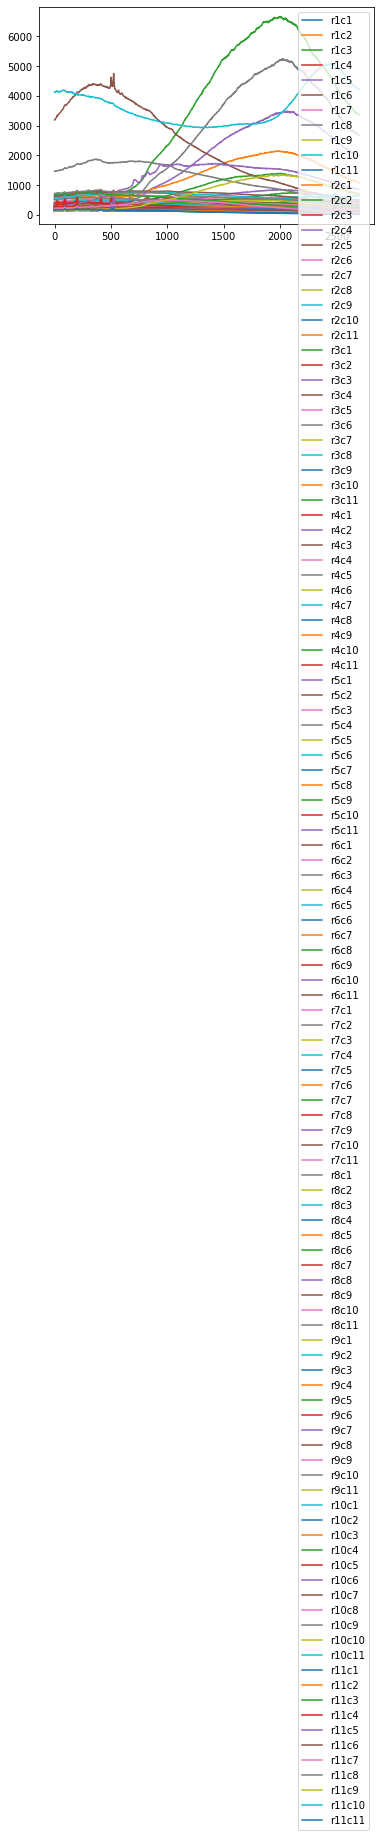

In [8]:
data.plot()

<AxesSubplot:>

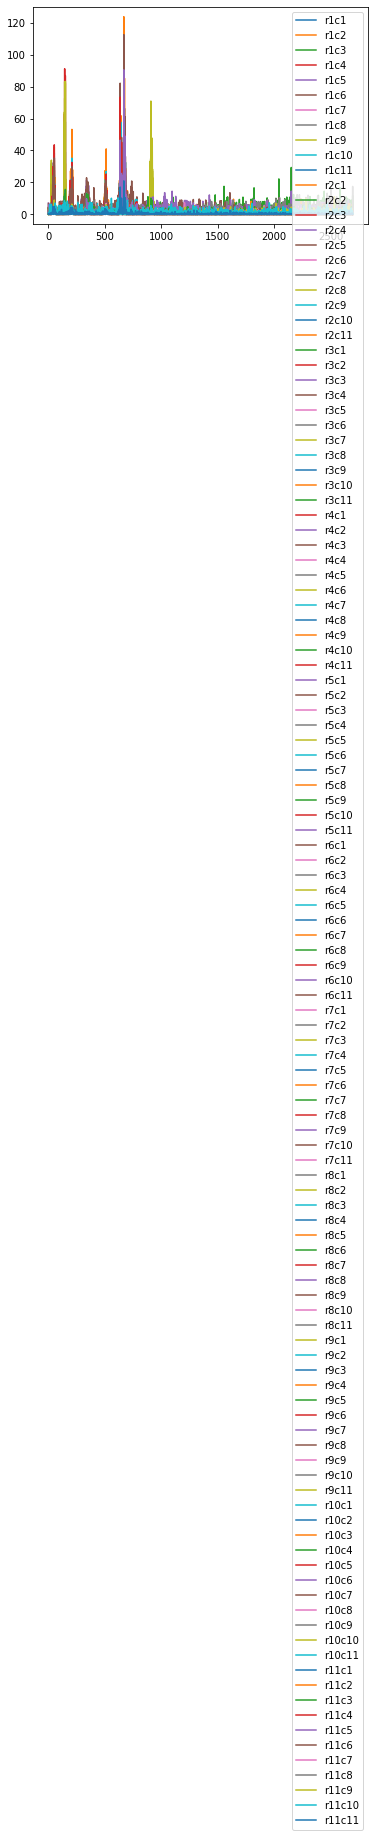

In [9]:
data_diff = np.abs(data_bkg.diff())
data_gradient = data_diff.divide(wl.diff(), axis=0)
data_gradient.plot()
# data_gradient.sum(1).plot()

There's no peak on the right (which was instead present in S1), need to investigate that further.

Labeled data stops around 1400 wl, therefore only that information is useful for clustering and for comparing labeled data.
Anyway, for experimentation purposes we can perform the clustering in different wl ranges, and analyse the performance of the clustering at different information levels.

How many peaks are in the data? What is considered a peak? $sample(wl)' > t$, where $t \ in [min(spec), max(spec)]$

By visually inspecting the data, a meaningful threshold might be around 10.

(<AxesSubplot:>, <AxesSubplot:>)

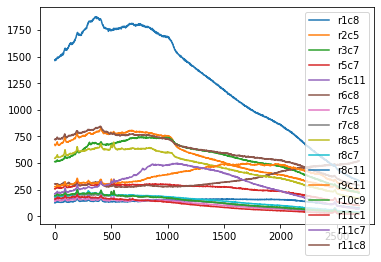

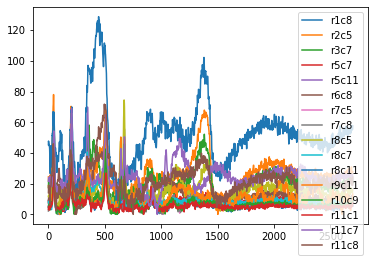

In [6]:
gradient_thr = 10

# Check if for some columns no peaks are detected
zero_peaks_col = list()
for col in data_gradient:
    if (data_gradient[col] > gradient_thr).sum() == 0:
        zero_peaks_col.append(col)

data[zero_peaks_col].plot(), data_bkg[zero_peaks_col].plot()

Threshold of 10 is too much for this data, removing a lot.

No peaks are actually in the data, also when looking at the filtered one. Therefore, peaks alone
are not a good clustering feature.

Will now investigate the power, to see if I can find meaningful information there.

<AxesSubplot:>

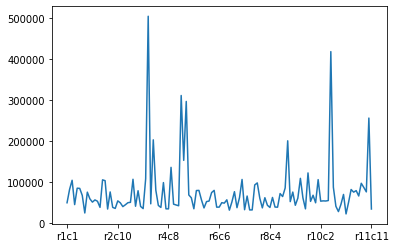

In [7]:
from scipy import integrate

data_integral = data_bkg.apply(lambda x: integrate.trapz(x, wl), axis=0)
data_integral.plot()

A similar pattern to the one from S1 is in the ingration part.